# Load Data

In [32]:
import torch
import pickle

# Load raw CTs

# Load the encoded data
all_encoded_cubes = torch.load('data/generated-data/vqgan_encoded_96.pt')#data/all_encoded_cubes.pt')

encoded_cubes_estimated_labels = torch.load('data/generated-data/seg_cubes_tensor.pt')

sampled_points_coordinates = torch.load('data/generated-data/sample_coordinates.pt')


# Load the list of patient IDs
with open('data/generated-data/filtered_ids.pkl', 'rb') as f:
    all_filtered_ids = pickle.load(f)


print(all_encoded_cubes.shape)
print(len(all_filtered_ids))
assert len(all_encoded_cubes) == len(all_filtered_ids)
assert len(encoded_cubes_estimated_labels) == len(all_filtered_ids)

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_2294/935794250.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_encoded_cubes = torch.load('data/generated-

torch.Size([46, 55, 8, 24, 24, 24])
46


/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_2294/935794250.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded_cubes_estimated_labels = torch.load('da

## Flatten vectors and Standardize

In [34]:
import torch
from typing import Optional, Tuple

def flatten_features(features: torch.Tensor) -> torch.Tensor:
    """
    Flatten the input features while keeping the dimension of 8 intact.

    Parameters:
        features (torch.Tensor): Original features of shape (n_samples, 55, 8, 24, 24, 24).

    Returns:
        torch.Tensor: Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
    """
    if not isinstance(features, torch.Tensor):
        raise TypeError("Input features must be a torch.Tensor.")

    # Get the shape of the input tensor
    n_samples, _, dim_8, *rest = features.shape

    # Ensure the dimension of 8 is in the correct position
    assert dim_8 == 8, "The third dimension must be 8."

    # Flatten the tensor while keeping the dimension of 8 intact
    flattened = features.permute(0, 2, 1, 3, 4, 5).contiguous().view(n_samples * 55 * 24 * 24 * 24, 8)
    
    return flattened


def unflatten_features(flattened: torch.Tensor, n_samples: int) -> torch.Tensor:
    """
    Un-flatten the input features back to their original shape.

    Parameters:
        flattened (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples.

    Returns:
        torch.Tensor: Original features of shape (n_samples, 55, 8, 24, 24, 24).
    """
    if not isinstance(flattened, torch.Tensor):
        raise TypeError("Input features must be a torch.Tensor.")
    
    # Define the expected dimensions
    num_items = 55
    num_channels = 8
    dim_size = 24
    
    # Calculate the expected size of the first dimension
    expected_first_dim = n_samples * num_items * dim_size * dim_size * dim_size
    
    if flattened.shape[0] != expected_first_dim:
        raise ValueError(
            f"First dimension of flattened tensor should be {expected_first_dim} "
            f"(n_samples * 55 * 24 * 24 * 24), but got {flattened.shape[0]}."
        )
    
    if flattened.shape[1] != num_channels:
        raise ValueError(
            f"The last dimension of flattened tensor should be {num_channels}, "
            f"but got {flattened.shape[1]}."
        )
    
    # Reshape to (n_samples, 55, 24, 24, 24, 8)
    reshaped = flattened.view(n_samples, num_items, dim_size, dim_size, dim_size, num_channels)
    
    # Permute to (n_samples, 55, 8, 24, 24, 24)
    original = reshaped.permute(0, 1, 5, 2, 3, 4).contiguous()
    
    return original


def extract_middle_vectors(flattened_features: torch.Tensor,
                           n_samples: int = all_encoded_cubes.shape[0],
                           n_j: int = 55,
                           n_x: int = 24,
                           n_y: int = 24,
                           n_z: int = 24,
                           middle_x: int = 12,
                           middle_y: int = 12,
                           middle_z: int = 12) -> (torch.Tensor, torch.Tensor):
    """
    Extract the middle vectors at position (i, j, 12, 12, 12, :) from the flattened tensor
    and return their corresponding indices.

    Parameters:
        flattened_features (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples (e.g., 50).
        n_j (int): Size of the second dimension (e.g., 55).
        n_x (int): Size of the third dimension (e.g., 24).
        n_y (int): Size of the fourth dimension (e.g., 24).
        n_z (int): Size of the fifth dimension (e.g., 24).
        middle_x (int): Middle index along the x-axis (e.g., 12).
        middle_y (int): Middle index along the y-axis (e.g., 12).
        middle_z (int): Middle index along the z-axis (e.g., 12).

    Returns:
        middle_vectors (torch.Tensor): Middle vectors of shape (n_samples * n_j, 8).
        indices (torch.Tensor): Indices of the middle vectors in the flattened tensor, shape (n_samples * n_j,).
    """
    def compute_middle_indices(n_samples: int, n_j: int, n_x: int, n_y: int, n_z: int,
                              middle_x: int, middle_y: int, middle_z: int) -> torch.Tensor:
        # Create tensors for i and j indices
        i_indices = torch.arange(n_samples).unsqueeze(1)  # Shape: (n_samples, 1)
        j_indices = torch.arange(n_j).unsqueeze(0)        # Shape: (1, n_j)

        # Calculate strides based on the permutation and flattening
        stride_j = n_x * n_y * n_z  # Stride for j dimension
        stride_x = n_y * n_z        # Stride for x dimension
        stride_y = n_z              # Stride for y dimension
        stride_z = 1                # Stride for z dimension

        # Compute the flattened indices using the formula:
        # index = i * (55 * 24 * 24 * 24) + j * (24 * 24 * 24) + 12 * (24 * 24) + 12 * 24 + 12
        indices = (i_indices * (n_j * stride_j) +
                   j_indices * stride_j +
                   middle_x * stride_x +
                   middle_y * stride_y +
                   middle_z * stride_z).view(-1)  # Shape: (n_samples * n_j,)

        return indices

    # Compute the indices for the middle vectors
    indices = compute_middle_indices(n_samples, n_j, n_x, n_y, n_z, middle_x, middle_y, middle_z)

    # Ensure that the indices are within the bounds of the flattened tensor
    if torch.any(indices >= flattened_features.shape[0]):
        raise IndexError("Computed indices are out of bounds.")

    # Extract the middle vectors using the computed indices
    middle_vectors = flattened_features[indices]  # Shape: (n_samples * n_j, 8)

    return middle_vectors, indices


def create_labels(n_samples=50, n_pancreas=10, n_background=45, D=24, H=24, W=24):
    """
    Create a labels tensor indicating pancreas (1) vs. background (0) for each voxel.

    Parameters:
        n_samples (int): Number of CT scans.
        n_pancreas (int): Number of pancreas points per CT scan.
        n_background (int): Number of background points per CT scan.
        D (int): Depth dimension size.
        H (int): Height dimension size.
        W (int): Width dimension size.

    Returns:
        torch.Tensor: Labels tensor of shape (n_samples * n_points * D * H * W,)
                      where n_points = n_pancreas + n_background.
    """
    # Total number of points per CT scan
    n_points = n_pancreas + n_background  # 55

    # Create labels for one CT scan: first 10 pancreas (1), next 45 background (0)
    labels_per_ct = torch.cat([
        torch.ones(n_pancreas, dtype=torch.long),
        torch.zeros(n_background, dtype=torch.long)
    ])  # Shape: [55]

    # Number of voxels per point
    n_voxels_per_point = D * H * W  # 24 * 24 * 24 = 13,824

    # Repeat each label for its corresponding voxels
    # Each point's label is repeated for all its voxels
    labels_per_voxel = labels_per_ct.repeat_interleave(n_voxels_per_point)  # Shape: [55 * 13,824]

    # Repeat for all CT scans
    labels = labels_per_voxel.repeat(n_samples)  # Shape: [50 * 55 * 13,824] = [38,016,000]

    return labels

In [35]:
# Flatten the features
flattened_features = flatten_features(all_encoded_cubes)
print(flattened_features.shape)

torch.Size([34974720, 8])


In [49]:
middle_vectors, middle_indices = extract_middle_vectors(flattened_features, n_samples=all_encoded_cubes.shape[0], n_j=55, n_x=24, n_y=24, n_z=24, middle_x=12, middle_y=12, middle_z=12)

middle_labels = create_labels(n_samples=all_encoded_cubes.shape[0], n_pancreas=10, n_background=45, D=24, H=24, W=24)[middle_indices]

In [50]:
middle_labels.shape

torch.Size([2530])

In [36]:
from sklearn.preprocessing import StandardScaler

scaled_data = StandardScaler().fit_transform(flattened_features)

## Apply PCA, Keep all Components

In [37]:
from sklearn.decomposition import PCA

full_pca = PCA().fit(scaled_data)

full_pca.explained_variance_

array([4.65311608, 1.21693998, 0.65168188, 0.43510554, 0.3304624 ,
       0.2708863 , 0.23339902, 0.20840902])

In [38]:
full_pca_data = full_pca.transform(scaled_data)

generated_labels = create_labels(n_samples=all_encoded_cubes.shape[0], n_pancreas=10, n_background=45, D=24, H=24, W=24)

# Function Definitions 📚

## Print Results and Save to File Functions

In [63]:
def print_results(results):
    """
    Print the evaluation results for both labeled and unlabeled metrics.

    Parameters:
        results (dict): Nested dictionaries containing evaluation metrics.
    """
    for dim_method, dim_results in results.items():
        for n_comp_key, clustering_results in dim_results.items():
            # Identify all unique metrics present
            metrics = set()
            for param_results in clustering_results.values():
                for eval_metrics in param_results.values():
                    metrics.update(eval_metrics.keys())
            metrics = sorted(metrics)  # Sort metrics for consistent ordering

            # Extract n_clusters values
            n_clusters_set = set()
            for param_results in clustering_results.values():
                n_clusters_set.update(param_results.keys())
            n_clusters_list = sorted(n_clusters_set)

            # Initialize a dictionary to hold DataFrames for each metric
            metric_dfs = {metric: pd.DataFrame(index=n_clusters_list) for metric in metrics}

            # Populate the DataFrames
            for cluster_key, param_results in clustering_results.items():
                for n_clusters, eval_metrics in param_results.items():
                    for metric in metrics:
                        if metric in eval_metrics and eval_metrics[metric] is not None:
                            metric_dfs[metric].at[n_clusters, cluster_key] = eval_metrics[metric]
                        else:
                            metric_dfs[metric].at[n_clusters, cluster_key] = None  # or pd.NA

            # Print each metric's DataFrame
            for metric, df in metric_dfs.items():
                print(f"\nResults for {dim_method} ({n_comp_key}) - {metric}:")
                print(df)

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clustering_metrics(clustering_results, 
                            reduction_method, 
                            n_components, 
                            algorithm_key, 
                            highlight_optimal=False, 
                            optimal_clusters=None,
                            save_path=None):
    """
    Plots Calinski-Harabasz Index and Davies-Bouldin Index against the number of clusters.

    Parameters:
        clustering_results (dict): Nested dictionary containing clustering metrics.
        reduction_method (str): Dimensionality reduction method used (e.g., 'PCA').
        n_components (str): Specific number of components used in reduction (e.g., 'n_components_8').
        algorithm_key (str): Key identifying the clustering algorithm and its parameters.
        highlight_optimal (bool): Whether to highlight an optimal number of clusters. Default is False.
        optimal_clusters (int): The number of clusters to highlight if highlight_optimal is True.
        save_path (str): File path to save the plot. If None, the plot is not saved. Default is None.

    Returns:
        None
    """
    
    # Validate inputs
    try:
        results_dict = clustering_results[reduction_method][n_components][algorithm_key]
    except KeyError as e:
        raise KeyError(f"Invalid key path in clustering_results: {e}")
    
    # Extract data
    n_clusters = []
    ch_index = []
    db_index = []
    
    for cluster_num, metrics in results_dict.items():
        n_clusters.append(cluster_num)
        ch_index.append(metrics.get('Calinski-Harabasz Index', np.nan))
        db_index.append(metrics.get('Davies-Bouldin Index', np.nan))
    
    # Create DataFrame
    df = pd.DataFrame({
        'n_clusters': n_clusters,
        'Calinski-Harabasz Index': ch_index,
        'Davies-Bouldin Index': db_index
    })
    
    # Sort by n_clusters
    df = df.sort_values(by='n_clusters')
    
    # Set the visual style
    sns.set(style="whitegrid")
    
    # Initialize the matplotlib figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot Calinski-Harabasz Index
    sns.lineplot(ax=axes[0], data=df, x='n_clusters', y='Calinski-Harabasz Index', marker='o', color='blue')
    axes[0].set_title('Calinski-Harabasz Index vs. Number of Clusters', fontsize=16)
    axes[0].set_xlabel('Number of Clusters (n_clusters)', fontsize=14)
    axes[0].set_ylabel('Calinski-Harabasz Index', fontsize=14)
    
    if highlight_optimal and optimal_clusters is not None:
        try:
            optimal_ch = df[df['n_clusters'] == optimal_clusters]['Calinski-Harabasz Index'].values[0]
            axes[0].scatter(optimal_clusters, optimal_ch, color='red', s=100, label=f'Optimal Clusters: {optimal_clusters}')
            axes[0].legend(fontsize=12)
        except IndexError:
            print(f"Optimal clusters value {optimal_clusters} not found in the data.")
    
    # Plot Davies-Bouldin Index
    sns.lineplot(ax=axes[1], data=df, x='n_clusters', y='Davies-Bouldin Index', marker='o', color='green')
    axes[1].set_title('Davies-Bouldin Index vs. Number of Clusters', fontsize=16)
    axes[1].set_xlabel('Number of Clusters (n_clusters)', fontsize=14)
    axes[1].set_ylabel('Davies-Bouldin Index', fontsize=14)
    
    if highlight_optimal and optimal_clusters is not None:
        try:
            optimal_db = df[df['n_clusters'] == optimal_clusters]['Davies-Bouldin Index'].values[0]
            axes[1].scatter(optimal_clusters, optimal_db, color='red', s=100, label=f'Optimal Clusters: {optimal_clusters}')
            axes[1].legend(fontsize=12)
        except IndexError:
            print(f"Optimal clusters value {optimal_clusters} not found in the data.")
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to {save_path}")
    
    # Display the plots
    plt.show()

In [65]:
def save_results_to_excel(results, filename):
    """
    Save the clustering evaluation results to an Excel file.

    Parameters:
        results (dict): Dictionary containing clustering evaluation results.
        filename (str): The output filename for the Excel file.
    """
    import pandas as pd
    from openpyxl import Workbook
    from openpyxl.utils.dataframe import dataframe_to_rows
    from openpyxl.styles import Font

    wb = Workbook()
    ws = wb.active
    ws.title = "Clustering Results"

    current_row = 1  # Start writing from the first row

    # Iterate over each dimensionality reduction method
    for method, method_results in results.items():
        for n_comp_key, clustering_results in method_results.items():
            # Identify all unique metrics present
            metrics = set()
            for param_results in clustering_results.values():
                for eval_metrics in param_results.values():
                    metrics.update(eval_metrics.keys())
            metrics = sorted(metrics)  # Sort metrics for consistent ordering

            # Extract n_clusters values
            n_clusters_set = set()
            for param_results in clustering_results.values():
                n_clusters_set.update(param_results.keys())
            n_clusters_list = sorted(n_clusters_set)

            # Initialize a dictionary to hold DataFrames for each metric
            metric_dfs = {metric: pd.DataFrame(index=n_clusters_list) for metric in metrics}

            # Populate the DataFrames
            for cluster_key, param_results in clustering_results.items():
                for n_clusters, eval_metrics in param_results.items():
                    for metric in metrics:
                        if metric in eval_metrics and eval_metrics[metric] is not None:
                            metric_dfs[metric].at[n_clusters, cluster_key] = eval_metrics[metric]
                        else:
                            metric_dfs[metric].at[n_clusters, cluster_key] = None  # or pd.NA

            # Write each metric's DataFrame to the worksheet
            for metric, df in metric_dfs.items():
                # Write the title for the metric
                title = f"Results for {method} ({n_comp_key}) - {metric}"
                ws.cell(row=current_row, column=1, value=title).font = Font(bold=True)
                current_row += 1  # Move to the next row

                # Write the DataFrame to the worksheet
                for r in dataframe_to_rows(df.reset_index(), index=False, header=True):
                    for c_idx, value in enumerate(r, start=1):
                        ws.cell(row=current_row, column=c_idx, value=value)
                    current_row += 1  # Move to the next row after writing each row of the DataFrame

                # Add 3 blank rows for spacing between different metrics
                current_row += 3

    # Save the workbook to the specified filename
    wb.save(filename)
    print(f"Results saved to {filename}")

## Clustering and Evaluation Functions

In [68]:
from tqdm import tqdm  # Import tqdm for progress bars
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


def cluster_and_evaluate(features, method, n_clusters, mode='Unlabeled', labels=None, compute_silhouette=False, **kwargs):
    """
    Perform clustering and evaluate the results using specified metrics based on the mode.
    
    Parameters:
        features (numpy.ndarray): Features to cluster.
        method (str): Clustering method to use ('kmeans', 'minibatchkmeans', 'gmm', 'dbscan', 'birch', 'optics').
        n_clusters (int or None): Number of clusters to form (if applicable).
        mode (str): 'Unlabeled' or 'Labeled'. Determines which metrics to compute.
        labels (numpy.ndarray or None): True labels for supervised evaluation. Required if mode is 'Labeled'.
        compute_silhouette (bool): Whether to compute the silhouette score. Default is False, as it's O(n^2)
        **kwargs: Additional parameters for the clustering algorithm.
    
    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    # Validate mode and labels
    if mode not in ['Unlabeled', 'Labeled']:
        raise ValueError("Mode must be either 'Unlabeled' or 'Labeled'.")
    
    if mode == 'Labeled' and labels is None:
        raise ValueError("Labels must be provided when mode is 'Labeled'.")
    
    # Perform clustering
    if method == 'kmeans':
        clustering_model = KMeans(n_clusters=n_clusters, random_state=42, **kwargs)
    elif method == 'minibatchkmeans':
        clustering_model = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, **kwargs)
    elif method == 'gmm':
        clustering_model = GaussianMixture(n_components=n_clusters, random_state=42, **kwargs)
    elif method == 'dbscan':
        clustering_model = DBSCAN(**kwargs)
    elif method == 'birch':
        clustering_model = Birch(n_clusters=n_clusters, **kwargs)
    elif method == 'optics':
        clustering_model = OPTICS(**kwargs)
    else:
        raise ValueError(f"Unsupported clustering method: {method}")
    
    clustering_model.fit(features)
    
    if hasattr(clustering_model, 'labels_'):
        cluster_labels = clustering_model.labels_
    else:
        cluster_labels = clustering_model.predict(features)
    
    # Initialize evaluation dictionary
    evaluation = {}
    
    # Compute supervised metrics if in 'Labeled' mode
    if mode == 'Labeled':
        ari = adjusted_rand_score(labels, cluster_labels)
        nmi = normalized_mutual_info_score(labels, cluster_labels)
        evaluation['Adjusted Rand Index'] = ari
        evaluation['Normalized Mutual Information'] = nmi
    
    # Compute unsupervised metrics
    unique_labels = set(cluster_labels)
    if len(unique_labels) > 1 and len(unique_labels) < len(features):
        try:
            # Too expensive, O(n^2)
            if compute_silhouette:
                silhouette_avg = silhouette_score(features, cluster_labels)
            calinski_harabasz = calinski_harabasz_score(features, cluster_labels)
            davies_bouldin = davies_bouldin_score(features, cluster_labels)
            if compute_silhouette:
                evaluation['Silhouette Score'] = silhouette_avg
            evaluation['Calinski-Harabasz Index'] = calinski_harabasz
            evaluation['Davies-Bouldin Index'] = davies_bouldin
        except Exception as e:
            # In case of any exception, set metrics to None
            if compute_silhouette:
                evaluation['Silhouette Score'] = None
            evaluation['Calinski-Harabasz Index'] = None
            evaluation['Davies-Bouldin Index'] = None
            print(f"Error computing metrics: {e}")
    else:
        # Not enough clusters to compute metrics
        if compute_silhouette:
            evaluation['Silhouette Score'] = None
        evaluation['Calinski-Harabasz Index'] = None
        evaluation['Davies-Bouldin Index'] = None
    
    return evaluation


def evaluate_dimred_clustering(features, labels=None, mode='Unlabeled',
                               dim_reduction_methods=['PCA', 't-SNE', 'UMAP'],
                               n_components_list=None, n_clusters_list=None,
                               clustering_methods=['kmeans'],
                               clustering_param_grid=None,
                               tsne_param_grid=None,
                               umap_param_grid=None,
                               compute_silhouette=False):
    """
    Evaluate clustering performance across different dimensionality reduction and clustering methods.
    """

    def apply_pca(data, n_components):
        pca = PCA(n_components=n_components, random_state=42)
        reduced_data = pca.fit_transform(data)
        explained_variance = pca.explained_variance_ratio_.sum()
        return reduced_data, explained_variance

    def get_clustering_param_grid(method, param_grid, n_clusters_list):
        if method in ['kmeans', 'minibatchkmeans', 'birch']:
            # Need to include n_clusters
            grid = []
            for params in ParameterGrid(param_grid):
                for n_clusters in n_clusters_list:
                    params_copy = params.copy()
                    params_copy['n_clusters'] = n_clusters
                    grid.append(params_copy)
            return grid
        elif method == 'gmm':
            # For GaussianMixture, the number of components is specified by n_components
            grid = []
            for params in ParameterGrid(param_grid):
                for n_components in n_clusters_list:
                    params_copy = params.copy()
                    params_copy['n_components'] = n_components
                    grid.append(params_copy)
            return grid
        elif method in ['dbscan', 'optics']:
            # DBSCAN and OPTICS do not require n_clusters
            return list(ParameterGrid(param_grid))
        else:
            # For any other methods, return the parameter grid as is
            return list(ParameterGrid(param_grid))

    # Initialize results dictionary
    results = {}

    # If n_components_list is None, only PCA is run with all components retained
    if n_components_list is None:
        n_components_list = [features.shape[1]]  # Use all components
        if any(method in ['t-SNE', 'UMAP'] for method in dim_reduction_methods):
            warnings.warn("n_components_list is None. Only PCA will be run with all components retained.")
            dim_reduction_methods = ['PCA']

    # Set default n_clusters_list if not provided
    if n_clusters_list is None:
        n_clusters_list = [2, 3, 4, 5, 6, 7]

    # Set default clustering_param_grid if not provided
    if clustering_param_grid is None:
        clustering_param_grid = {
            'kmeans': {
                'n_init': [10],         # 10 is typically sufficient for convergence
                'max_iter': [300],      # 300 is a common default that balances speed and performance
            },
            'minibatchkmeans': {
                'n_init': [10],
                'max_iter': [100],
                'batch_size': [200],
            },
            'gmm': {
                'covariance_type': ['full'],  # 'diag' can be added if needed
                'tol': [1e-3],
            },
            'dbscan': {
                'eps': [0.5],
                'min_samples': [5],
            },
            'birch': {
                'threshold': [0.5, 1.0],
                'branching_factor': [50, 100],
                'compute_labels': [True, False],
            },
            'optics': {
                'min_samples': [5, 10],
                'xi': [0.05, 0.1],
                'min_cluster_size': [0.05, 0.1],  # Can also be int values
            },
        }

    # Iterate over dimensionality reduction methods
    for dim_name in dim_reduction_methods:
        # Initialize a nested dictionary to store results
        results[dim_name] = {}

        if dim_name == 'PCA':
            for n_components in n_components_list:
                # Apply PCA
                reduced_features, _ = apply_pca(features, n_components)
                # Initialize key for this n_components
                key = f"n_components_{n_components}"
                results[dim_name][key] = {}

                # Iterate over clustering methods
                for method in clustering_methods:
                    print(f"Now using Clustering method: {method} on {dim_name} with {n_components} components")
                    # Get hyperparameter grid for this method
                    if method in clustering_param_grid:
                        param_grid = get_clustering_param_grid(method, clustering_param_grid[method], n_clusters_list)
                    else:
                        param_grid = [{}]  # If no hyperparameters, use default parameters

                    # Iterate over parameter combinations
                    for params in tqdm(param_grid, desc=f"Running Hyperparameter Combinations for {method}", leave=True):
                        # Extract n_clusters and create a unique key excluding n_clusters
                        params_clean = params.copy()
                        n_clusters = params_clean.pop('n_clusters', None)
                        n_components_gmm = params_clean.pop('n_components', None)  # For GMM
                        if method == 'gmm':
                            n_clusters = n_components_gmm
                        param_str = ';'.join([f"{k}={v}" for k, v in params_clean.items()])
                        if method == 'gmm' and n_components_gmm is not None:
                            cluster_key = f"{method};{param_str}"
                        else:
                            cluster_key = f"{method};{param_str}" if param_str else method

                        # Perform clustering and evaluation
                        evaluation = cluster_and_evaluate(
                            reduced_features,
                            method=method,
                            n_clusters=n_clusters,
                            mode=mode,
                            labels=labels,
                            compute_silhouette=compute_silhouette,
                            **params_clean
                        )

                        # Initialize the results dictionary for this cluster_key if not already
                        if cluster_key not in results[dim_name][key]:
                            results[dim_name][key][cluster_key] = {}

                        # Store evaluation metrics with n_clusters as a key if applicable
                        if method in ['kmeans', 'minibatchkmeans', 'birch', 'gmm']:
                            results[dim_name][key][cluster_key][n_clusters] = evaluation
                        else:
                            # For methods like DBSCAN and OPTICS, n_clusters is determined by the algorithm
                            # Here, we can use a fixed key or include some parameter info
                            results[dim_name][key][cluster_key][-1] = evaluation

        elif dim_name in ['t-SNE', 'UMAP']:
            # Placeholder for other dimensionality reduction methods
            # You can implement them similarly to PCA
            pass  # Implementation can be added as needed

    return results

# Evaluations

## Full Data, 8 components PCA

I.e. full $24^3$ cubes used

### Unlabeled Metrics

Silhouette Score is $O(n^2)$, so it is not feasible to calculate it for large datasets.


From results on first 200k vectors, MinibatchKmeans with 4 components is by far the best, decreasing steadily with more classes

- [ ] Let's make a more fine-grained analysis of the best number of clusters for MinibatchKMeans
    - [ ] on the whole dataset

In [18]:
# %load_ext line_profiler

In [ ]:
# %lprun -f evaluate_dimred_clustering -f cluster_and_evaluate evaluate_dimred_clustering(scaled_data[:10000],    mode='Unlabeled',    n_components_list=None,    dim_reduction_methods=['PCA'],    n_clusters_list=[10])

In [16]:
full_components_results = evaluate_dimred_clustering(
    scaled_data[:200000],
    mode='Unlabeled',
    n_components_list=None,
    dim_reduction_methods=['PCA'],
    # n_clusters_list=list(range(4, 40,3)),
    n_clusters_list=list(range(2, 20,1)),  # More fine-grained search
    clustering_methods=['minibatchkmeans'],
)

Now using Clustering method:  minibatchkmeans


Running Hyperparameter Combinations for minibatchkmeans:   0%|          | 0/12 [00:00<?, ?it/s]

Running Hyperparameter Combinations for minibatchkmeans: 100%|██████████| 12/12 [00:01<00:00,  7.65it/s]


In [12]:
full_components_dbscan_results = evaluate_dimred_clustering(
    scaled_data[:200000],
    mode='Unlabeled',
    n_components_list=None,
    dim_reduction_methods=['PCA'],
    n_clusters_list=list(range(4, 40,3)),
    clustering_methods=['dbscan'],
)

Now using Clustering method:  dbscan


Running Hyperparameter Combinations for dbscan: 100%|██████████| 1/1 [01:29<00:00, 89.36s/it]


In [13]:
full_components_gmm_results = evaluate_dimred_clustering(
    scaled_data[:100000],
    mode='Unlabeled',
    n_components_list=None,
    dim_reduction_methods=['PCA'],
    # n_clusters_list=list(range(4, 40,3)),
    n_clusters_list=list(range(4, 40,3)),
    clustering_methods=['gmm'],
)

Now using Clustering method:  gmm


Running Hyperparameter Combinations for gmm: 100%|██████████| 12/12 [05:30<00:00, 27.57s/it]


In [ ]:
full_components_gmm_results = evaluate_dimred_clustering(
    scaled_data[:200000],
    mode='Unlabeled',
    n_components_list=None,
    dim_reduction_methods=['PCA'],
    n_clusters_list=list(range(4, 40,3)),
    clustering_methods=['optics', 'birch'],
)

In [23]:
full_components_results

{'PCA': {'n_components_8': {'minibatchkmeans;batch_size=200;max_iter=100;n_init=10': {2: {'Calinski-Harabasz Index': np.float64(89378.49667401116),
     'Davies-Bouldin Index': np.float64(1.0590941200811157)},
    3: {'Calinski-Harabasz Index': np.float64(67486.29518996732),
     'Davies-Bouldin Index': np.float64(1.3717087609913012)},
    4: {'Calinski-Harabasz Index': np.float64(53901.21213108704),
     'Davies-Bouldin Index': np.float64(1.505569972459845)},
    5: {'Calinski-Harabasz Index': np.float64(44078.77590178128),
     'Davies-Bouldin Index': np.float64(1.7564529533969266)},
    6: {'Calinski-Harabasz Index': np.float64(40768.77080109427),
     'Davies-Bouldin Index': np.float64(1.5782001059943367)},
    7: {'Calinski-Harabasz Index': np.float64(36425.3163910164),
     'Davies-Bouldin Index': np.float64(1.5468004703462948)},
    8: {'Calinski-Harabasz Index': np.float64(32941.44888515306),
     'Davies-Bouldin Index': np.float64(1.7055919106407105)},
    9: {'Calinski-Haraba

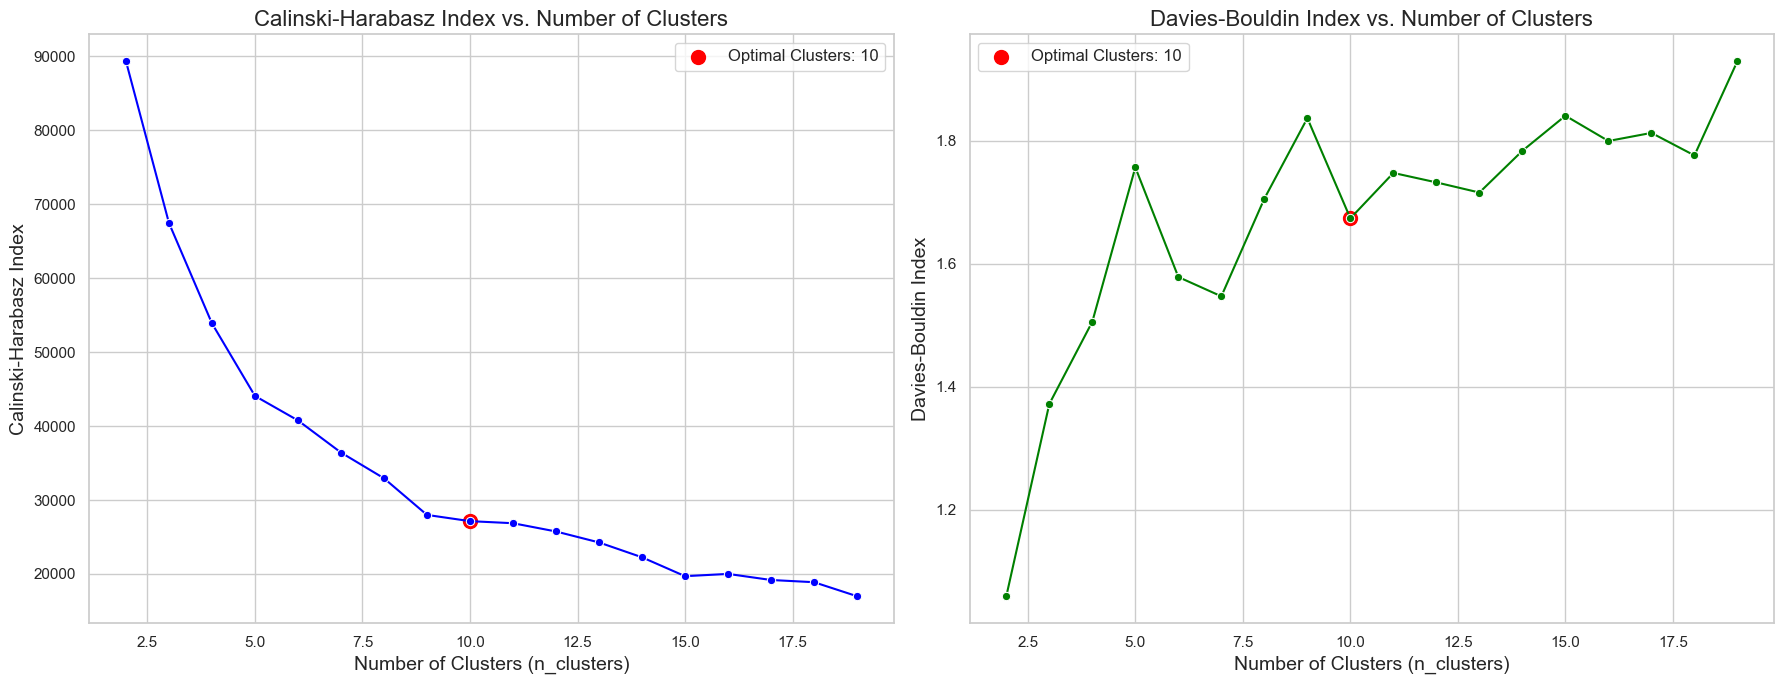

In [29]:
plot_clustering_metrics(full_components_results, 'PCA', 'n_components_8', 'minibatchkmeans;batch_size=200;max_iter=100;n_init=10', highlight_optimal=True, optimal_clusters=10)

In [22]:
print_results(full_components_results)#, list(range(4, 40,3)))


Results for PCA (n_components_8) - Calinski-Harabasz Index:
    minibatchkmeans;batch_size=200;max_iter=100;n_init=10
2                                        89378.496674    
3                                        67486.295190    
4                                        53901.212131    
5                                        44078.775902    
6                                        40768.770801    
7                                        36425.316391    
8                                        32941.448885    
9                                        27987.218443    
10                                       27143.626961    
11                                       26864.138195    
12                                       25747.041253    
13                                       24264.436471    
14                                       22254.237123    
15                                       19699.994204    
16                                       20006.940557    
17         

In [17]:
save_results_to_excel(full_components_results, 'full_components_results.xlsx')

Results saved to full_components_results.xlsx


In [14]:
save_results_to_excel(full_components_gmm_results, 'full_components_results_gmm.xlsx')

Results saved to full_components_results_gmm.xlsx


In [15]:
save_results_to_excel(full_components_dbscan_results, 'full_components_results_dbscan.xlsx')

Results saved to full_components_results_dbscan.xlsx


### Labels: pancreas vs. Not

### Labels: Multi-organ Interpolation

## Middle Vectors, Full PCA

### Unlabeled Metrics

In [51]:
middle_vectors.shape

torch.Size([2530, 8])

In [69]:
full_components_results = evaluate_dimred_clustering(
    middle_vectors,
    mode='Unlabeled',
    n_components_list=None,
    dim_reduction_methods=['PCA'],
    # n_clusters_list=list(range(4, 40,3)),
    n_clusters_list=list(range(2, 20,1)),  # More fine-grained search
    clustering_methods=['minibatchkmeans', 'dbscan', 'gmm', 'birch', 'optics'],
    compute_silhouette=True
)

Now using Clustering method: minibatchkmeans on PCA with 8 components


Running Hyperparameter Combinations for minibatchkmeans: 100%|██████████| 18/18 [00:01<00:00, 13.09it/s]


Now using Clustering method: dbscan on PCA with 8 components


Running Hyperparameter Combinations for dbscan: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Now using Clustering method: gmm on PCA with 8 components


Running Hyperparameter Combinations for gmm: 100%|██████████| 18/18 [00:03<00:00,  5.85it/s]


Now using Clustering method: birch on PCA with 8 components


Running Hyperparameter Combinations for birch: 100%|██████████| 144/144 [00:22<00:00,  6.36it/s]


Now using Clustering method: optics on PCA with 8 components


Running Hyperparameter Combinations for optics: 100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


In [59]:
full_components_results

{'PCA': {'n_components_8': {'minibatchkmeans;batch_size=200;max_iter=100;n_init=10': {2: {'Silhouette Score': np.float64(0.3454574435835699),
     'Calinski-Harabasz Index': np.float64(767.6611529679029),
     'Davies-Bouldin Index': np.float64(1.237161085217247)},
    3: {'Silhouette Score': np.float64(0.3820150352286765),
     'Calinski-Harabasz Index': np.float64(716.6202814653077),
     'Davies-Bouldin Index': np.float64(1.2096610331816327)},
    4: {'Silhouette Score': np.float64(0.37855958815508356),
     'Calinski-Harabasz Index': np.float64(492.56485626847774),
     'Davies-Bouldin Index': np.float64(1.7667637323547152)},
    5: {'Silhouette Score': np.float64(0.18040980065478424),
     'Calinski-Harabasz Index': np.float64(518.318053180004),
     'Davies-Bouldin Index': np.float64(1.48072662935513)},
    6: {'Silhouette Score': np.float64(0.14413196887920052),
     'Calinski-Harabasz Index': np.float64(457.4794826120921),
     'Davies-Bouldin Index': np.float64(1.6160999729984

In [70]:
print_results(full_components_results)


Results for PCA (n_components_8) - Calinski-Harabasz Index:
     minibatchkmeans;batch_size=200;max_iter=100;n_init=10  \
-1                                                 NaN       
 2                                          767.661153       
 3                                          716.620281       
 4                                          492.564856       
 5                                          518.318053       
 6                                          457.479483       
 7                                          409.792370       
 8                                          382.643434       
 9                                          357.198415       
 10                                         315.869361       
 11                                         328.239310       
 12                                         294.230879       
 13                                         270.867191       
 14                                         259.024073       
 15      

In [71]:
save_results_to_excel(full_components_results, 'middle_vectors_results.xlsx')

Results saved to middle_vectors_results.xlsx


# Dimensionality Reduction Results

In [ ]:
pca_results = evaluate_dimred_clustering(flattened_features, labels, n_components_list=range(2, 54, 2), dim_reduction_methods=['PCA'])

In [ ]:
# Further PCA results. Clearly best results for between 34 and 40 components. Run more experiments in that range.
more_pca_results = evaluate_dimred_clustering(flattened_features_std, labels, n_components_list=range(3, 4, 1), dim_reduction_methods=['PCA'])

In [ ]:
tsne_results = evaluate_dimred_clustering(flattened_features_std, labels, n_components_list=range(2, 54, 2), dim_reduction_methods=['t-SNE'])

In [ ]:
# Define t-SNE parameter grid
tsne_param_grid = {
    'perplexity': list(range(40, 52, 2)),    # Must be less than n. samples
    'learning_rate': [10],                   # fixed at 10
    'n_iter': [3000],                        # fixed at 3000
    'n_components': list(range(3, 4, 1)),  # 30 to 54 inclusive, increments of 2
}

# Set n_clusters fixed at 7
n_clusters_list = list(range(2, 8))

# Call the function
tsne_best_results = evaluate_dimred_clustering(
    features=flattened_features_std,
    labels=labels,
    dim_reduction_methods=['t-SNE'],
    n_clusters_list=n_clusters_list,
    tsne_param_grid=tsne_param_grid
)

In [ ]:
tsne_best_results

{'t-SNE': {'learning_rate=10;n_components=3;n_iter=3000;perplexity=40':   Adjusted Rand Index Normalized Mutual Information
  2            0.290252                       0.20166
  3            0.339846                      0.328172
  4            0.219502                      0.248856
  5            0.208069                      0.239755
  6            0.135034                      0.182717
  7            0.150077                      0.213162,
  'learning_rate=10;n_components=3;n_iter=3000;perplexity=42':   Adjusted Rand Index Normalized Mutual Information
  2            0.230638                      0.333781
  3            0.213345                      0.291925
  4            0.228512                      0.236625
  5            0.198979                      0.185571
  6            0.073926                      0.158817
  7            0.101186                      0.148793,
  'learning_rate=10;n_components=3;n_iter=3000;perplexity=44':   Adjusted Rand Index Normalized Mutual Informat

In [ ]:
umap_results = evaluate_dimred_clustering(flattened_features_std, labels, n_components_list=range(2, 54, 2), dim_reduction_methods=['UMAP'])

In [ ]:
# Initialize an empty dictionary to store the merged results
merged_results = {}

# Merge PCA results
merged_results.update(pca_results)

# Merge t-SNE results
merged_results.update(tsne_results)

# Merge UMAP results
merged_results.update(umap_results)

# Now merged_results contains results from all three methods

## Results 📊

Best results occur for PCA(n_components=37) and KMeans(n_clusters=6), with an ARI of 0.513 and NMI of 0.415

In [ ]:
print_results(pca_results, n_clusters_list=range(2, 8))


Results for PCA - Adjusted Rand Index:
         2         4         6         8         10        12        14  \
2  0.105422  0.105422  0.105422   0.16362  0.132286  0.132286  0.132286   
3  0.163203  0.158358  0.138364  0.268685  0.020754  0.110171  0.137151   
4  0.161454  0.224447  0.206023  0.154407  0.086646  0.143533  0.225663   
5  0.054793  0.230545  0.238667   0.25608  0.189553  0.188191  0.276914   
6  0.056264  0.223586  0.223586  0.313787  0.220103  0.222912  0.225116   
7   0.03494  0.206704  0.275968   0.27165  0.087995  0.256775  0.330367   

         16        18        20  ...        34        36        38        40  \
2  0.163027  0.132286  0.132286  ... -0.012354  0.051662 -0.012354 -0.072663   
3  0.148408  0.137151  0.107662  ...  0.144451  0.075999 -0.009909 -0.044438   
4  0.114589  0.180407  0.195068  ...  0.199143 -0.066184   0.00304  0.143533   
5  0.224054  0.039817  0.210131  ...  0.075707  0.501698  0.435102  -0.08382   
6  0.129543  0.132812   0.20837  .

In [ ]:
print_results(tsne_results, n_clusters_list=range(2, 8))


Results for t-SNE - Adjusted Rand Index:
         2         4         6         8         10        12        14  \
2  0.348496 -0.024468 -0.019339 -0.062517 -0.024468   0.07905   0.07905   
3  0.158427 -0.022389  -0.02084 -0.064962  -0.04646  0.017204  0.051047   
4  0.121754  0.025294  -0.01257 -0.082634 -0.066184 -0.006495  0.003843   
5  0.087196   0.02262 -0.024559 -0.043537  0.002619  0.018164 -0.017015   
6   0.05538  0.024676 -0.000516 -0.055303  0.029484  0.002511 -0.018204   
7  0.057078  0.027556   -0.0208 -0.020338  0.042498  0.020171 -0.052773   

         16        18        20  ...        34        36        38        40  \
2   0.07905   0.07905 -0.024468  ... -0.024468   0.07905 -0.024468 -0.024468   
3  0.155519  0.051047  -0.04646  ...   0.17252  0.051047  -0.04646 -0.000363   
4  0.124267  0.025641  0.025641  ...  0.094342  0.124267  0.025641  0.003843   
5  0.129978  0.095708  0.002619  ...  0.034261  0.095708  0.002619 -0.017015   
6  0.051184  0.163967  -0.01503 

In [ ]:
print_results(umap_results, n_clusters_list=range(2, 8))


Results for UMAP - Adjusted Rand Index:
         2         4         6         8         10        12        14  \
2  0.192351   0.16362  0.076649  0.040948  0.040948  0.061754  0.061754   
3   0.09794  0.145803  0.146435  0.156966   0.18606  0.200857  0.200857   
4  0.069605  0.133676  0.073904  0.194103   0.17143  0.196352  0.129246   
5  0.053648  0.084218  0.093677  0.145929  0.173827  0.117848  0.103965   
6  0.038888   0.06793  0.089413  0.096501  0.130077  0.143777  0.108178   
7  0.081612  0.096401  0.111682  0.095118  0.088227  0.074125  0.113087   

         16        18        20  ...        34        36        38        40  \
2  0.082548  0.042989  0.040948  ...  0.042309  0.061754  0.061754  0.082548   
3  0.187155  0.099125  0.206882  ...  0.078272   0.17129  0.158146  0.216583   
4  0.172255  0.142185  0.130533  ...  0.110177  0.165306   0.15581  0.172394   
5  0.177315   0.16164  0.194036  ...  0.126155  0.128671   0.08088  0.151652   
6  0.165327  0.048248  0.168643  

In [ ]:
import matplotlib.pyplot as plt

def plot_pca_variance_explained(results):
    """
    Plot the variance explained by PCA for different numbers of components.

    Parameters:
        results (dict): The results dictionary returned by evaluate_clustering.
    """
    if 'PCA' not in results:
        print("PCA results not found in the results dictionary.")
        return

    pca_results = results['PCA']
    n_components = []
    variance_explained = []

    # Extract n_components and variance explained
    for key in sorted(pca_results.keys(), key=lambda x: int(x.split('_')[-1])):
        n = int(key.split('_')[-1])
        var_exp = pca_results[key]['Variance Explained'].iloc[0]  # Same for all n_clusters
        n_components.append(n)
        variance_explained.append(var_exp)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(n_components, variance_explained, marker='o', linestyle='-')
    plt.title('Variance Explained by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained')
    plt.grid(True)
    plt.xticks(n_components)  # Ensure all n_components are shown on x-axis
    plt.show()

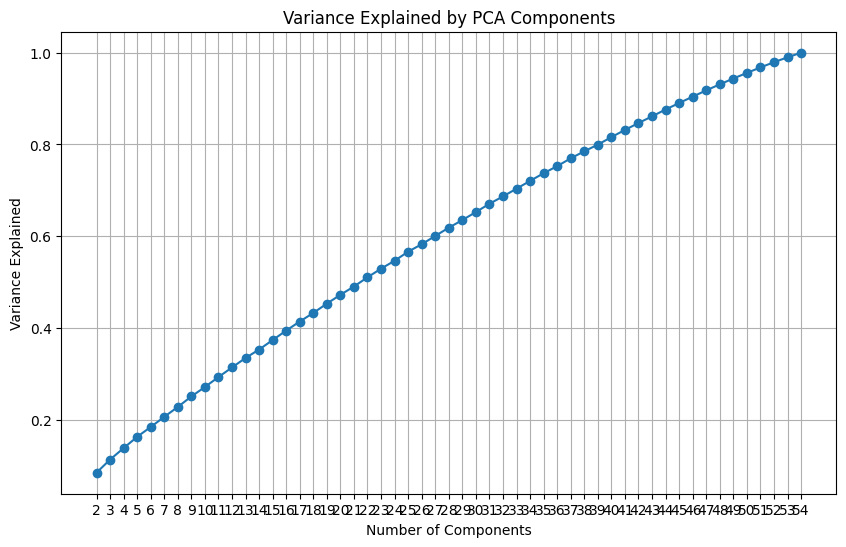

In [ ]:
plot_pca_variance_explained(pca_results)

# Plotting

First, perform best clustering - need to find optimal hyperparameters above

<font color='cyan'>From Excel spreadsheet, best choice was: PCA - 36 components - 6 clusters AND T-SNE: 7 clusters, learning_rate	n_components	n_iter	perplexity 10	42	1000	50</font>

## Setup

In [ ]:
patient_ids = healthy_patient_ids + panc_patient_ids
labels = labels.tolist()

### Plotting Code (Long)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import colormaps  # Import the correct module for colormaps

# Function to plot 2D scatter plot with annotations and cluster centroids with variance ellipses
def plot_2d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 2D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth labels.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 2D
    features_2d = features_high_dim
    if features_high_dim.shape[1] > 2:
        pca_2d = PCA(n_components=2)
        features_2d = pca_2d.fit_transform(features_high_dim)
    
    plt.figure(figsize=(12, 8))
    
    # Define colors for labels
    label_colors = {0: 'blue', 1: 'red'}
    colors = [label_colors[label] for label in labels]
    
    # Plot data points
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=colors, s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # Add annotations for patient IDs
    # for i, patient_id in enumerate(patient_ids):
    #     plt.annotate(patient_id, (features_2d[i, 0], features_2d[i, 1]), fontsize=8, alpha=0.6)

    # Compute and plot centroids and variance ellipses
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')  # Use the new colormap API without the 'lut' parameter

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_2d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)
        covariance = np.cov(cluster_points, rowvar=False)
        
        if covariance.shape == (2, 2):
            eigenvalues, eigenvectors = np.linalg.eigh(covariance)
            
            # Sort eigenvalues and eigenvectors
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            
            # Compute angle for the ellipse
            angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
            
            # Width and height are "full" widths, so we multiply by 2 to get full length
            width, height = 2 * np.sqrt(eigenvalues)
            
            # Create and add the ellipse patch
            ellipse = Ellipse(xy=centroid, width=width, height=height, angle=angle,
                              edgecolor=cmap(i), facecolor='none', linewidth=2)
            plt.gca().add_patch(ellipse)
        
        # Plot centroid
        plt.scatter(centroid[0], centroid[1], marker='X', s=200, c=[cmap(i)], label=f'Centroid {cluster}')

    # Create legend for labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=10) for label, color in label_colors.items()]
    
    # Create legend for centroids
    centroid_handles = [plt.Line2D([0], [0], marker='X', color='w', label=f'Centroid {cluster}',
                                   markerfacecolor=cmap(i), markersize=10) for i, cluster in enumerate(unique_clusters)]
    
    # Combine both legends
    plt.legend(handles=handles + centroid_handles, loc='best')
    plt.grid(True)
    plt.show()

# Function to plot 3D scatter plot with annotations and cluster centroids
def plot_3d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 3D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth labels.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 3D
    features_3d = features_high_dim
    if features_high_dim.shape[1] > 3:
        pca_3d = PCA(n_components=3)
        features_3d = pca_3d.fit_transform(features_high_dim)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for labels
    label_colors = {0: 'blue', 1: 'red'}
    colors = [label_colors[label] for label in labels]
    
    # Plot data points
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
                         c=colors, s=50, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    # Add annotations for patient IDs
    # Annotations in 3D are more cluttered, so we skip them for now
    # for i, patient_id in enumerate(patient_ids):
        # ax.text(features_3d[i, 0], features_3d[i, 1], features_3d[i, 2], patient_id, size=8, alpha=0.6)
    
    # Compute and plot centroids
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')  # Use the new colormap API without the 'lut' parameter

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_3d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)
        # Plot centroid
        ax.scatter(centroid[0], centroid[1], centroid[2], marker='X', s=200, c=[cmap(i)], label=f'Centroid {cluster}')

    # Create legend for labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=10) for label, color in label_colors.items()]
    
    # Create legend for centroids
    centroid_handles = [plt.Line2D([0], [0], marker='X', color='w', label=f'Centroid {cluster}',
                                   markerfacecolor=cmap(i), markersize=10) for i, cluster in enumerate(unique_clusters)]
    
    # Combine both legends
    ax.legend(handles=handles + centroid_handles, loc='best')
    plt.show()


import plotly.graph_objects as go
from sklearn.decomposition import PCA
import numpy as np
import plotly

import plotly.graph_objs as go
import plotly
from sklearn.decomposition import PCA
import numpy as np

def plot_3d_interactive(features_high_dim, labels, patient_ids, clusters, title, plot_axes=False):
    """
    Creates an interactive 3D PCA scatter plot using Plotly with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth labels.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 3D
    features_3d = features_high_dim
    if features_high_dim.shape[1] > 3:
        pca_3d = PCA(n_components=3)
        features_3d = pca_3d.fit_transform(features_high_dim)
    
    # Define colors for labels
    label_colors = {0: 'blue', 1: 'red'}
    colors = [label_colors[label] for label in labels]

    # Create a Plotly scatter plot for the data points
    scatter = go.Scatter3d(
        x=features_3d[:, 0],
        y=features_3d[:, 1],
        z=features_3d[:, 2],
        mode='markers',  # Changed from 'markers+text' to 'markers'
        marker=dict(
            size=5,
            color=colors,  # Use label colors for data points
            opacity=0.8
        ),
        text=patient_ids,  # Patient IDs for hover
        hovertemplate='<b>%{text}</b><br>Cluster: %{marker.color}<extra></extra>'
    )

    # Compute centroids
    unique_clusters = np.unique(clusters)
    cluster_colors = plotly.colors.qualitative.T10  # Use a qualitative colormap for centroids

    # List to hold centroid traces
    centroid_traces = []

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_3d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)

        # Create a scatter plot for each centroid
        centroid_trace = go.Scatter3d(
            x=[centroid[0]],
            y=[centroid[1]],
            z=[centroid[2]],
            mode='markers',
            marker=dict(
                size=5,
                color=cluster_colors[i % len(cluster_colors)],  # Cycle through colors
                symbol='x',
                opacity=0.5
            ),
            name=f'Centroid {cluster}'
        )
        centroid_traces.append(centroid_trace)

    # Create the layout for the Plotly figure
    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(visible=plot_axes),  # Hide X-axis
            yaxis=dict(visible=plot_axes),  # Hide Y-axis
            zaxis=dict(visible=plot_axes),  # Hide Z-axis
        ),
        showlegend=False
    )

    # Combine scatter and centroid traces
    fig = go.Figure(data=[scatter] + centroid_traces, layout=layout)
    fig.show()

## Best PCA

In [ ]:
from sklearn.decomposition import PCA

best_PCA = PCA(n_components=36, random_state=42)

best_pca_features = best_PCA.fit_transform(flattened_features_std)

In [ ]:
from sklearn.cluster import KMeans

best_pca_clustering = KMeans(n_clusters=7, random_state=42)

In [ ]:
best_pca_clusters = best_pca_clustering.fit_predict(best_pca_features)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
best_pca_features.shape

(55, 36)

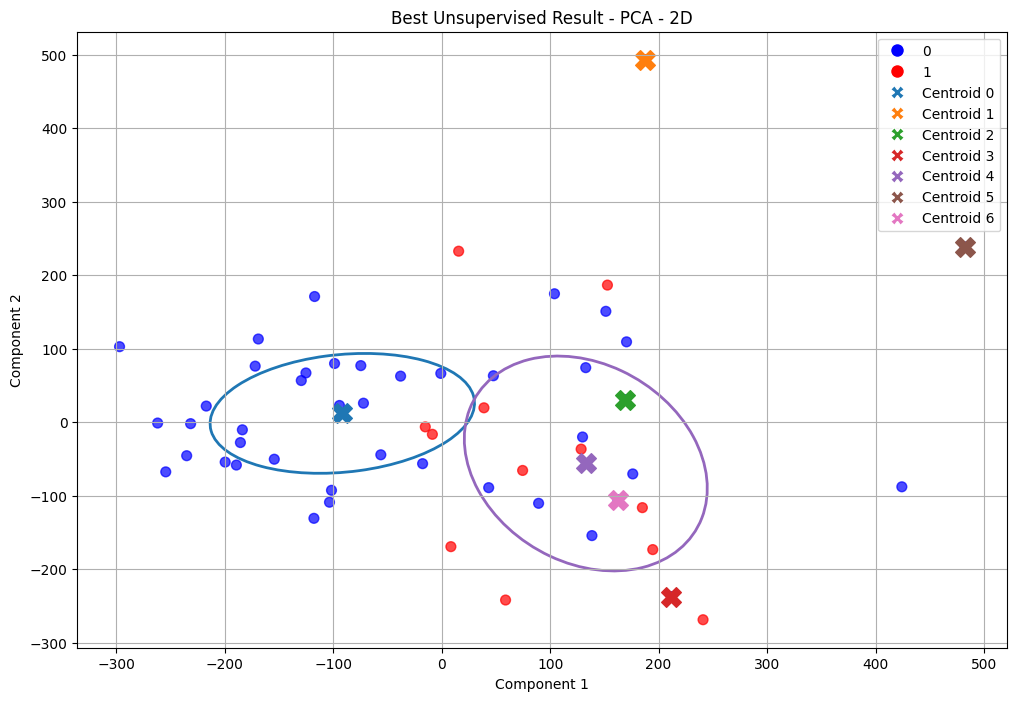

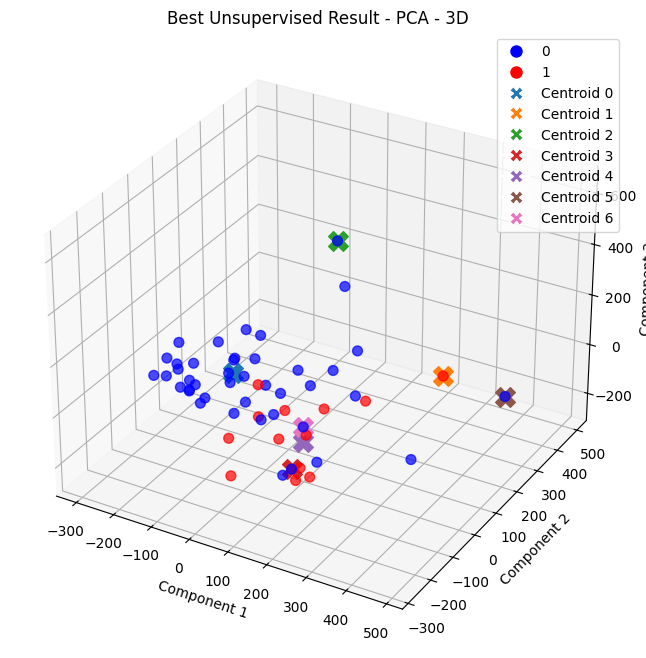

In [ ]:
# --- Plotting the Results ---

# Plot the best unsupervised result in 2D
plot_2d(best_pca_features, labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_pca_features, labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_pca_features,
    labels=labels,
    patient_ids=patient_ids,
    clusters=best_pca_clusters,
    title='Best Unsupervised Result - PCA - 3D (Interactive)'
)

## Best T-SNE

In [ ]:
from sklearn.manifold import TSNE

best_tsne = TSNE(n_components=42, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')

best_tsne_features = best_tsne.fit_transform(flattened_features_std)

In [ ]:
best_tsne_clustering = KMeans(n_clusters=7, random_state=42)

best_tsne_clusters = best_tsne_clustering.fit_predict(best_tsne_features)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



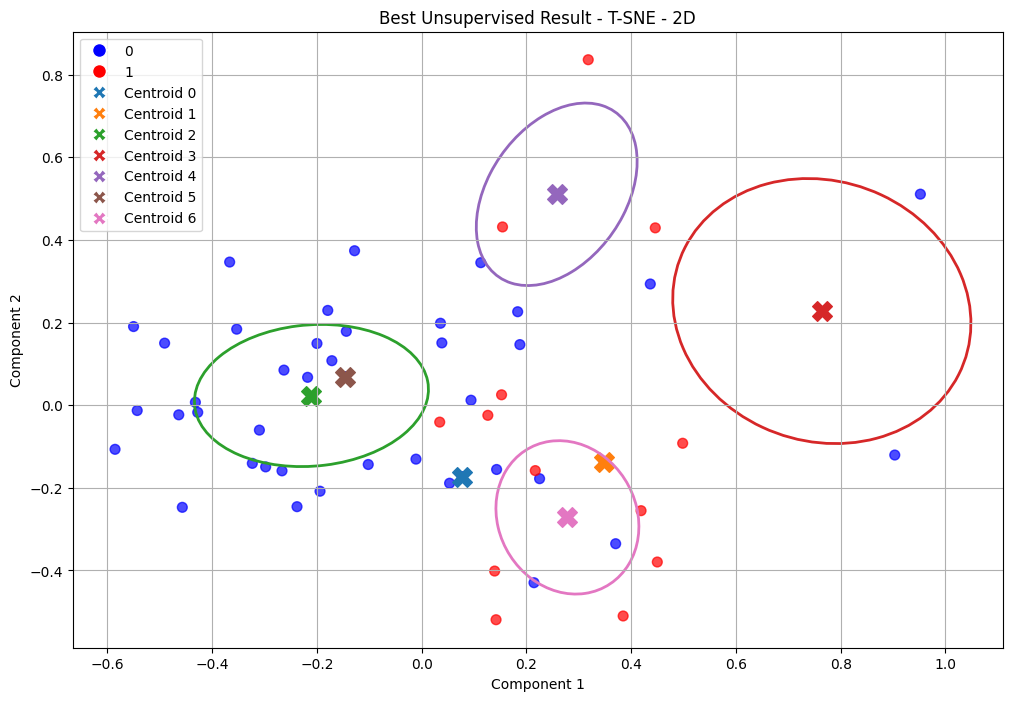

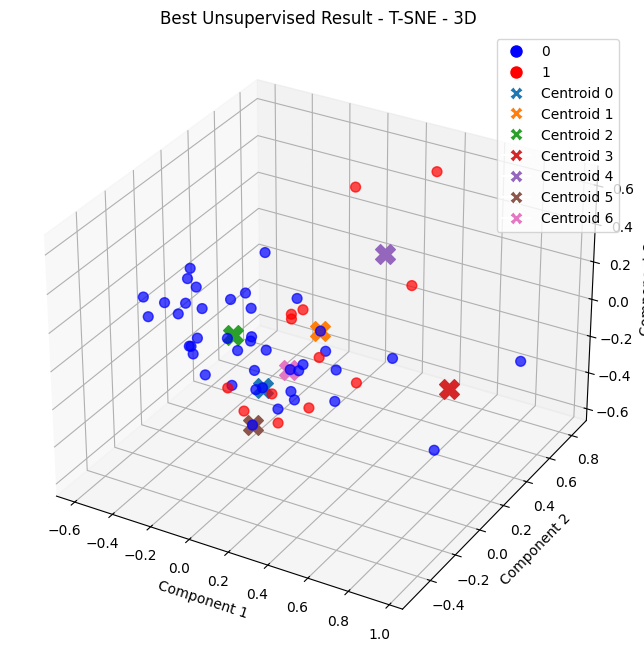

In [ ]:
plot_2d(best_tsne_features, labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_tsne_features, labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_tsne_features,
    labels=labels,
    patient_ids=patient_ids,
    clusters=best_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)',
    plot_axes=True
)

Outlier 5070

![5070.png](mkdown-imgs/5070.png)


Outlier 3427

![3427.png](mkdown-imgs/3427.png)


Outlier 928 - I think this CT is just Shifted from the rest, so it appears as an outlier



![928.png](mkdown-imgs/928.png)

## T-SNE w/ only 2,3 components (Worse)

In [ ]:
best_2d_tsne = TSNE(n_components=2, perplexity=40, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_2d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

best_3d_tsne = TSNE(n_components=3, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_3d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

In [ ]:
best_2d_tsne_features = best_2d_tsne.fit_transform(flattened_features_std)
best_3d_tsne_features = best_3d_tsne.fit_transform(flattened_features_std)

best_2d_tsne_clusters = best_2d_tsne_clusterer.fit_predict(best_2d_tsne_features)
best_3d_tsne_clusters = best_3d_tsne_clusterer.fit_predict(best_3d_tsne_features)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



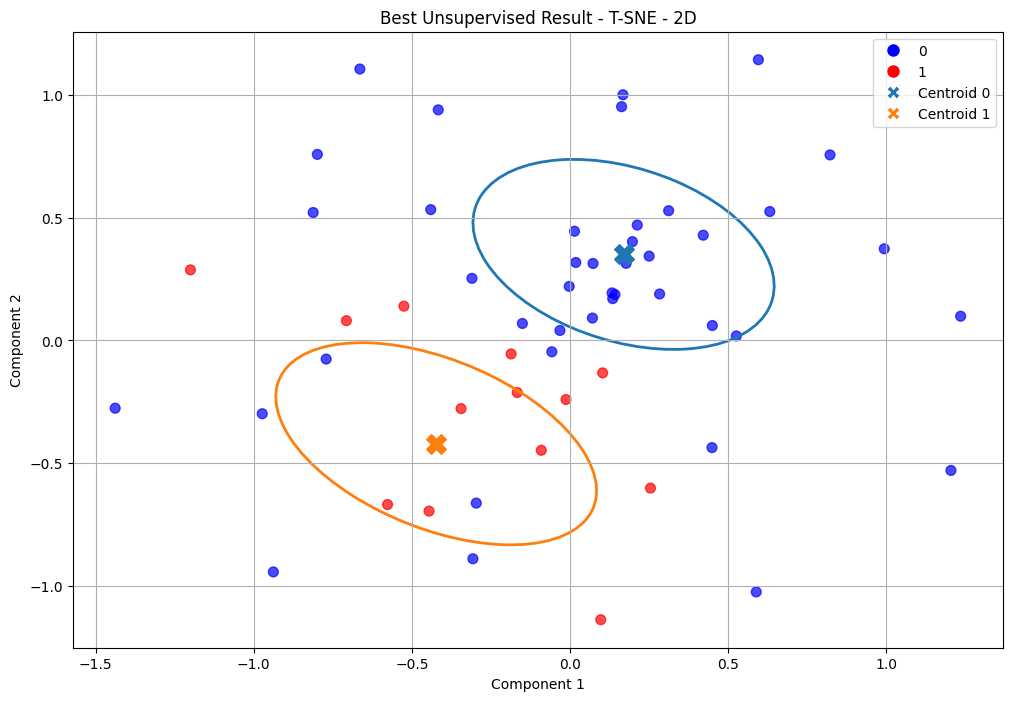

In [ ]:
plot_2d(best_2d_tsne_features, labels, patient_ids, best_2d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

In [ ]:
best_3d_tsne_features.shape

(55, 3)

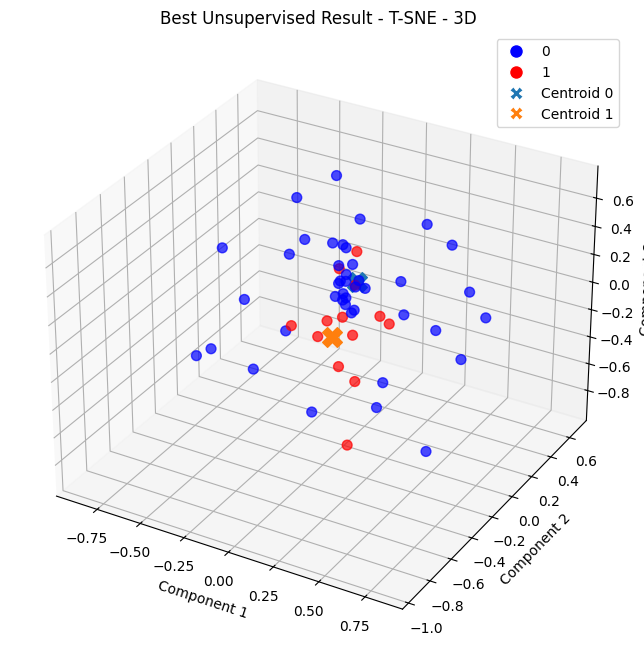

In [ ]:
plot_3d(best_3d_tsne_features, labels, patient_ids, best_3d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_3d_tsne_features,
    labels=labels,
    patient_ids=patient_ids,
    clusters=best_3d_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)')

    